In [1]:
library(ggplot2)
library(dplyr)
library(data.table)

data <- fread('http://mlr.cs.umass.edu/ml/machine-learning-databases/autos/imports-85.data', data.table = F)
head(data,10)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
1,158,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710
1,?,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920
1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875
0,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160,5500,16,22,?


At first glance, the data contained missing values and does not have the lables the its attributes. As such, the first task here is to renaming the columns so that we can have a better understanding of the data when visualising and building models.

In [3]:
colnames(data) <- c('symboling', 'normalized-losses', 'make', 'fuel-type',
                    'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
                    'length', 'width', 'height', 'curb-weight', 'engine-type',
                    'num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio',
                    'horsepower','peak-rpm','city-mpg','highway-mpg','price')
names(data) <- gsub(x = names(data), pattern = "-", replacement = "")  
str(data)

'data.frame':	205 obs. of  26 variables:
 $ symboling       : int  3 3 1 2 2 2 1 1 1 0 ...
 $ normalizedlosses: chr  "?" "?" "?" "164" ...
 $ make            : chr  "alfa-romero" "alfa-romero" "alfa-romero" "audi" ...
 $ fueltype        : chr  "gas" "gas" "gas" "gas" ...
 $ aspiration      : chr  "std" "std" "std" "std" ...
 $ numofdoors      : chr  "two" "two" "two" "four" ...
 $ bodystyle       : chr  "convertible" "convertible" "hatchback" "sedan" ...
 $ drivewheels     : chr  "rwd" "rwd" "rwd" "fwd" ...
 $ enginelocation  : chr  "front" "front" "front" "front" ...
 $ wheelbase       : num  88.6 88.6 94.5 99.8 99.4 ...
 $ length          : num  169 169 171 177 177 ...
 $ width           : num  64.1 64.1 65.5 66.2 66.4 66.3 71.4 71.4 71.4 67.9 ...
 $ height          : num  48.8 48.8 52.4 54.3 54.3 53.1 55.7 55.7 55.9 52 ...
 $ curbweight      : int  2548 2548 2823 2337 2824 2507 2844 2954 3086 3053 ...
 $ enginetype      : chr  "dohc" "dohc" "ohcv" "ohc" ...
 $ numofcylinders  : chr 

Now that renaming had been done. Let's impute the missing values with the appropriate replacements. Furthermore, as many columns were not categorised correctly, identifying them and changing their attribute is also done in the following.

In [4]:
for(i in 1:ncol(data)){
  
  data[,i] = ifelse(data[,i] == '?', NA, data[,i])
}  
wrong_colums = c("normalizedlosses","bore","stroke","horsepower","peakrpm","price")
data[,wrong_colums] = apply(data[,wrong_colums], 2, function(x) as.numeric(as.character(x)));
data$normalizedlosses = NULL
numeric_colums = select_if(data,is.numeric) 
numeric_names = colnames(numeric_colums)
factor_columns = select_if(data,is.character)
factor_names = colnames(factor_columns)
data[,c(factor_names)] = lapply(data[,c(factor_names)],factor)                            

It is noticed that the factor "number of doors" only has two missing values. As such, they would be replaced with the median value, which is "four" in this case. On the other hand, the other numeric missing values are imputed with their columns mean.

In [5]:
which(is.na(data$numofdoors)) 
data[c(28,64),5] = "four"

data[,c(numeric_names)] =lapply(data[,c(numeric_names)], function(x) replace(x, is.na(x), mean(x, na.rm = TRUE)))
sapply(data, function(x) sum(is.na(x)))

[1] 28 64

symboling             make         fueltype       aspiration 
               0                0                0                0 
      numofdoors        bodystyle      drivewheels   enginelocation 
               0                0                0                0 
       wheelbase           length            width           height 
               0                0                0                0 
      curbweight       enginetype   numofcylinders       enginesize 
               0                0                0                0 
      fuelsystem             bore           stroke compressionratio 
               0                0                0                0 
      horsepower          peakrpm          citympg       highwaympg 
               0                0                0                0 
           price 
               0

Now that's the data had been tidied up, let's explore which variable is the most important using different methods. 

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



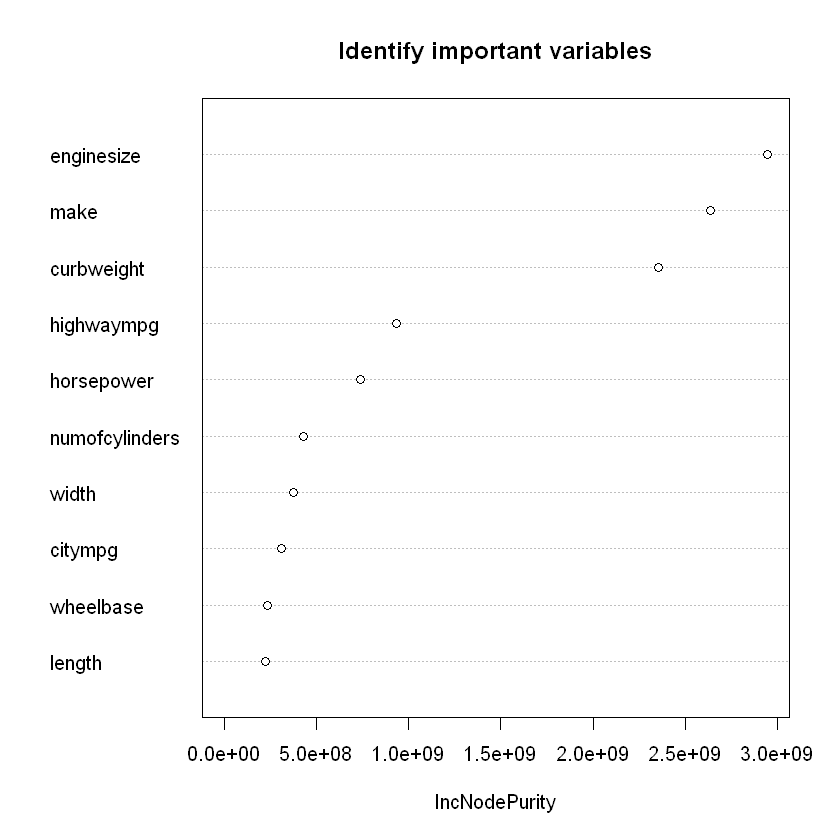

In [9]:
library(randomForest)
set.seed(124)
model_iv = randomForest(price ~.,data = data, ntree = 30)
varImpPlot(model_iv, sort = T, n.var = 10, main = "Identify important variables")

Enginesize, make, highwaympg and curbweight were identified as the most important variables using the Random Forest.
Now that's we know which variable has more impacts than others, some visulisation can now be done to extract further information for the mentioned attributes. 

In [16]:
important_variables = c("enginesize","curbweight","horsepower","highwaympg","width","height","citympg","drivewheels","wheelbase","fuelsystem","make")

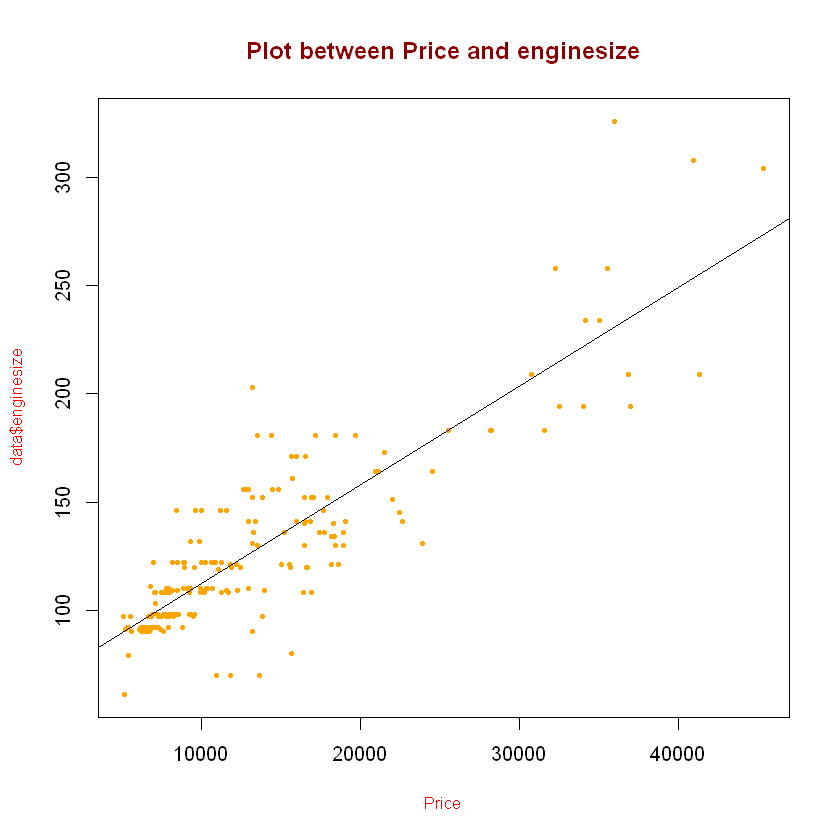

In [11]:
plot(~data$price+data$enginesize,ylab="enginesize",xlab="Price",main="Plot between Price and enginesize",cex=0.8,cex.lab=0.8,cex.main=1.2,pch=20,col.lab="red",col="orange",col.main="red4")
abline(lm(data$enginesize~data$price))

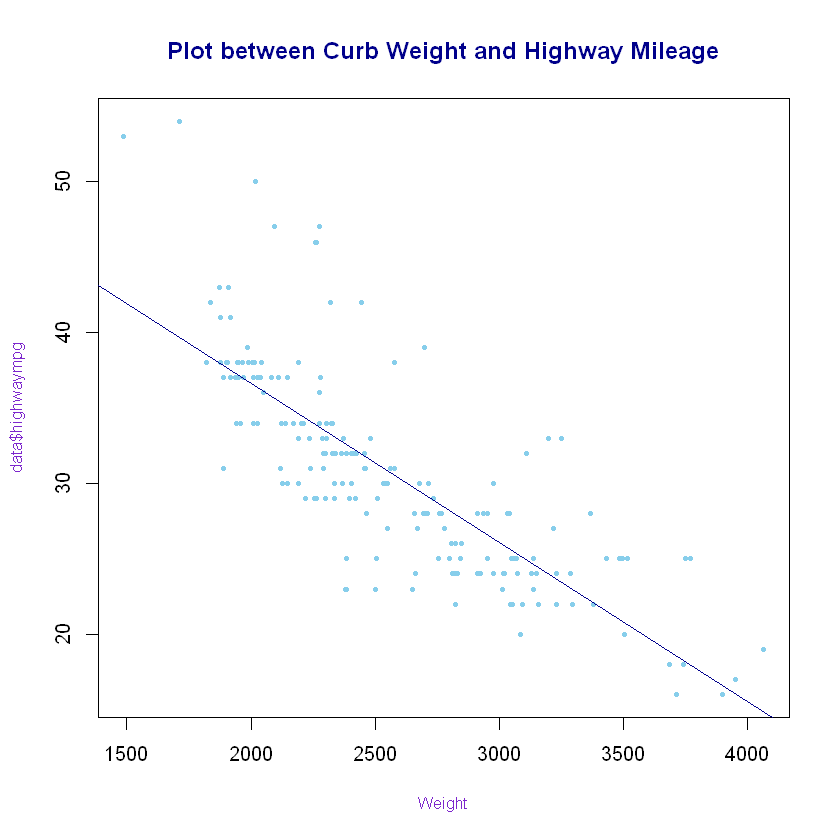

In [12]:
plot(~data$curbweight+data$highwaympg,xlab="Weight",main="Plot between Curb Weight and Highway Mileage",cex=0.8,cex.lab=0.8,cex.main=1.2,pch=20,ylab="City Mileage",col.lab="purple3",col="skyblue",col.main="darkblue")
abline(lm(data$highwaympg~data$curbweight),par(lwd=1.8),col='darkblue')

In [13]:
library(corrplot)
a<-cor(data[,c(numeric_names)])
corrplot.mixed(corr=a,upper='ellipse',tl.pos='lt')

ERROR: Error in library(corrplot): there is no package called 'corrplot'


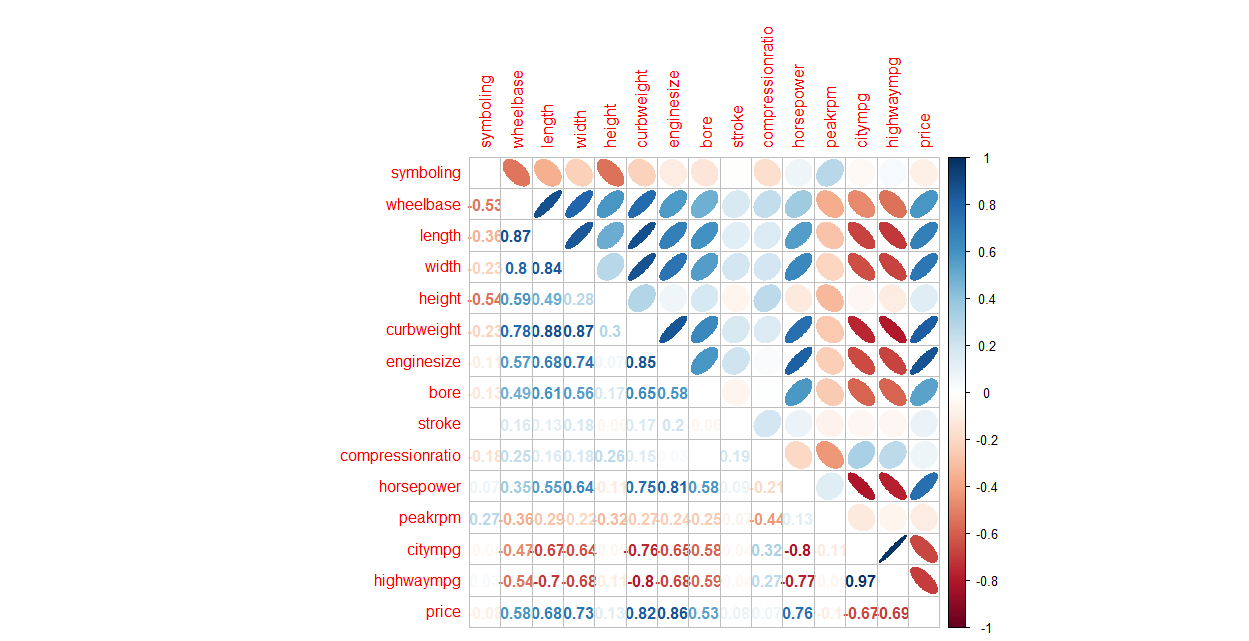

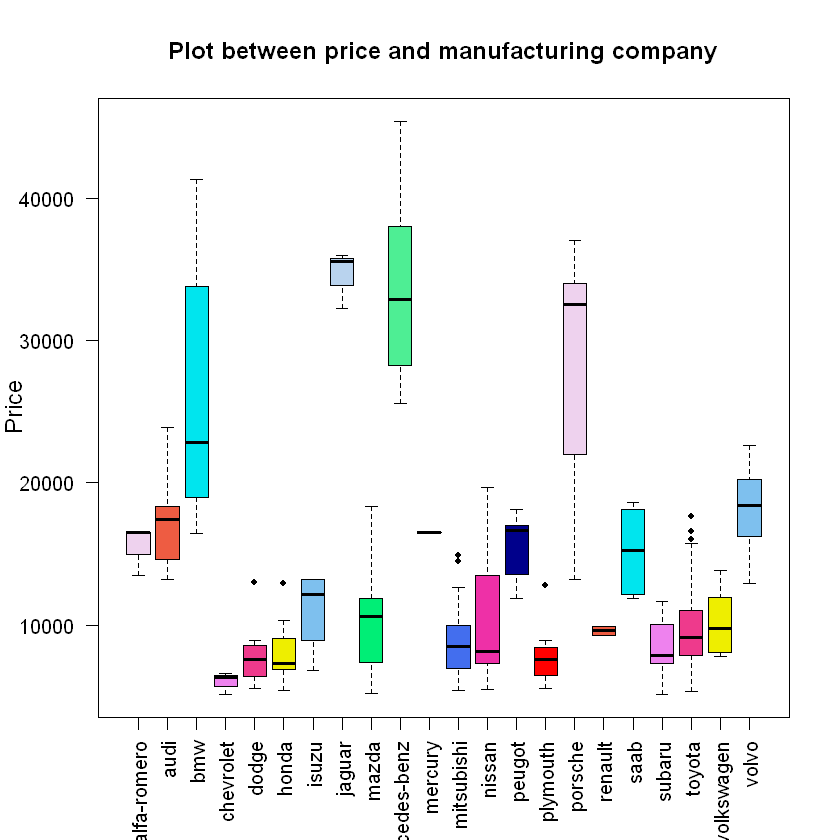

In [14]:
plot(data$price~data$make,xlab="",ylab="Price",main="Plot between price and manufacturing company", las = 2,
     col=c("thistle2","tomato2","turquoise2","violet","violetred2","yellow2",
           "skyblue2","slategray2","springgreen2","seagreen2","rosybrown2",
           "royalblue2","maroon2","darkblue","red"),
     cex.lab=1.2,cex.axis =1,pch=20)

Model building steps 

Using simple linear regression 


Call:
lm(formula = price ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6011.5  -983.9     0.0   835.6  8498.5 

Coefficients: (4 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -3.629e+04  1.758e+04  -2.064 0.040805 *  
symboling            -6.133e+01  2.658e+02  -0.231 0.817828    
makeaudi             -1.060e+03  2.441e+03  -0.434 0.664675    
makebmw               4.994e+03  2.459e+03   2.031 0.044082 *  
makechevrolet        -5.885e+03  2.353e+03  -2.501 0.013508 *  
makedodge            -6.501e+03  1.942e+03  -3.348 0.001040 ** 
makehonda            -3.725e+03  2.297e+03  -1.622 0.107082    
makeisuzu            -1.050e+03  2.136e+03  -0.492 0.623717    
makejaguar           -2.572e+03  2.951e+03  -0.871 0.384939    
makemazda            -3.314e+03  1.799e+03  -1.843 0.067439 .  
makemercedes-benz     1.422e+03  2.649e+03   0.537 0.592181    
makemercury          -4.029e+03  3.098

Warning message:
"not plotting observations with leverage one:
  19, 30, 47, 50, 59, 76, 126, 130"Warning message:
"not plotting observations with leverage one:
  19, 30, 47, 50, 59, 76, 126, 130"


Call:
lm(formula = price ~ ., data = data[, c(important_variables, 
    "price")])

Residuals:
     Min       1Q   Median       3Q      Max 
-15578.1  -1070.6      6.2    954.2  10523.6 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       25159.590  18596.983   1.353 0.177932    
enginesize           74.661     15.720   4.750 4.39e-06 ***
curbweight            3.427      1.932   1.774 0.077968 .  
horsepower            1.567     17.523   0.089 0.928868    
highwaympg         -233.155    162.735  -1.433 0.153815    
width              -365.701    308.076  -1.187 0.236906    
height             -227.192    181.155  -1.254 0.211556    
citympg             185.920    188.360   0.987 0.325057    
drivewheelsfwd      578.815   1294.292   0.447 0.655310    
drivewheelsrwd      334.865   1532.648   0.218 0.827318    
wheelbase            64.310    108.224   0.594 0.553168    
fuelsystem2bbl     1490.825   2206.413   0.676 0.500185    
fuelsystem4bbl   

Warning message:
"not plotting observations with leverage one:
  30, 47, 76"Warning message:
"not plotting observations with leverage one:
  30, 47, 76"

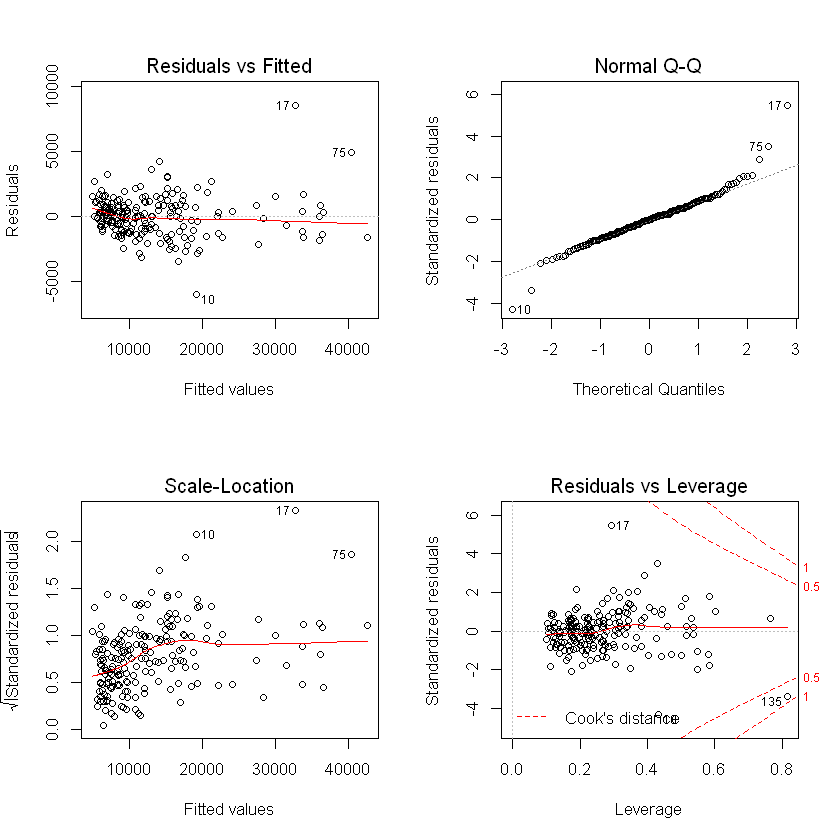

    Predicted price Actual Price
1         14977.236     13495.00
2         14977.236     16500.00
3         16540.529     16500.00
4         14499.968     13950.00
5         18277.337     17450.00
6         17583.228     15250.00
7         16668.332     17710.00
8         17045.340     18920.00
9         17919.945     23875.00
10        18367.979     13207.13
11        20266.665     16430.00
12        20266.665     16925.00
13        25419.925     20970.00
14        25608.429     21105.00
15        26177.779     24565.00
16        30188.647     30760.00
17        30791.433     41315.00
18        30230.457     36880.00
19         3541.035      5151.00
20         7180.004      6295.00
21         7299.961      6575.00
22         6307.843      5572.00
23         5891.792      6377.00
24         8570.531      7957.00
25         6249.119      6229.00
26         6324.521      6692.00
27         6324.521      7609.00
28         8831.893      8558.00
29         9414.779      8921.00
30        

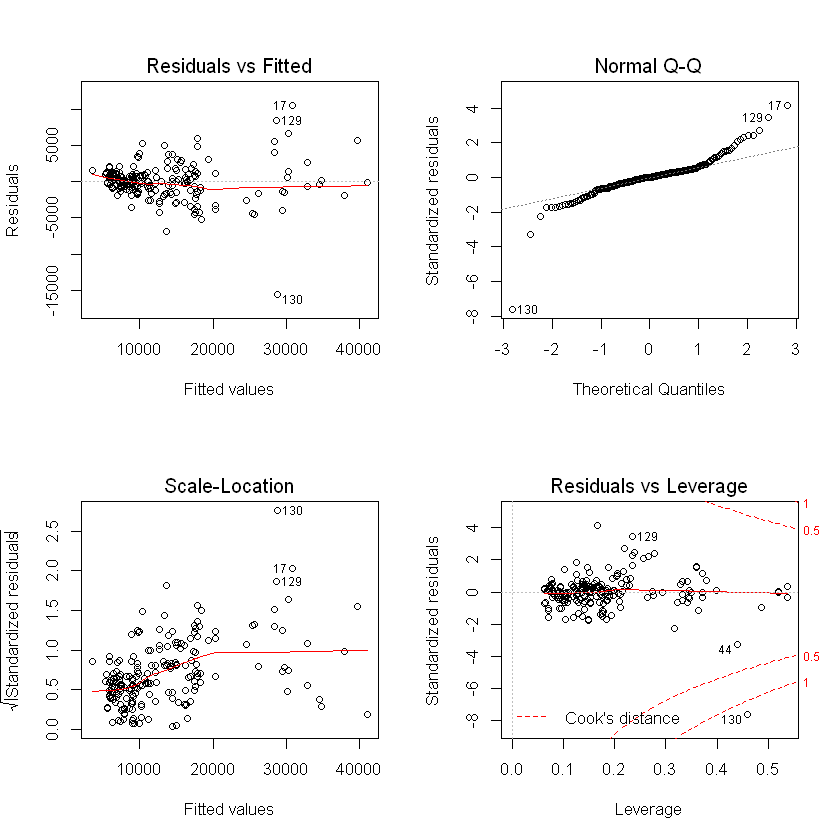

In [17]:
lm_model = lm(price ~., data = data)
summary(lm_model)
par(mfrow=c(2,2))
plot(lm_model)


lm_model2 = lm(price ~., data = data[,c(important_variables,"price")])
summary(lm_model2)
par(mfrow=c(2,2))
plot(lm_model2)
b<-cbind('Predicted price'=fitted(lm_model2),'Actual Price'=data$price)
print(b)